In [94]:
import numpy
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt

In [95]:
# Function that uses Delaunay Triangulation to determine whether a point exists in the hull
def in_hull(p, hull):
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p) >= 0

In [96]:
def in_support_polygon(point, support_list_x, support_list_z):
    """
        Function that determines whether build is stable with param 'point' - xCOM, zCOM
        Based on whether x_com and z_com COM values fall within support polygon
        Params support_list_x and support_list_z containing coordinates that make point cloud (maybe combine into one?)
    """
    support_polygon_vertices = list()  # array containing x-z coordinates
    # points = numpy.random.randint(1, 10, size=(6, 3))   # generate 6 random points in 2-D space
    points = numpy.column_stack((support_list_x, support_list_z))  # X-Z coordinates where y=0

    hull = ConvexHull(points)
    for item in hull.vertices:
        support_polygon_vertices.append(points[item])
    print(support_polygon_vertices)

    # 3 following lines can be commented out when used in actual learning process
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        plt.title('Boundary of Support Polygon')
        plt.xlabel('x')
        plt.ylabel('z', rotation=0)
    plt.show()  # gives visual representation of convex hull of a point cloud

    return in_hull([point], points)  # Pass in point and point cloud to in_hull function

In [97]:
# Function that uses center of mass equation
def calc_center_of_mass(list_param, mass):
    temp_num = 0  # for temporary calculations for equations
    temp_dem = 0  # for temporary calculations for equations
    for item in list_param:
        temp_num += mass*item
        temp_dem += mass
    return temp_num / temp_dem

In [98]:
# Function that returns center of mass x,y,z values
def find_center_of_mass(array_param):
    mass_list_x = []
    mass_list_y = []
    mass_list_z = []
    support_list_x = []
    support_list_z = []

    for x in range(len(array_param)):
        for y in range(len(array_param[x])):
            for z in range(len(array_param[x, y])):
                if array_param[x, y, z] == 1:
                    mass_list_x.append(x+0.5)
                    mass_list_y.append(y+0.5)
                    mass_list_z.append(z+0.5)
                    if y == 0:
                        # Each point has a boundary of 4 vertices
                        support_list_x.append(x)
                        support_list_z.append(z)
                        support_list_x.append(x+1)
                        support_list_z.append(z)
                        support_list_x.append(x)
                        support_list_z.append(z+1)
                        support_list_x.append(x+1)
                        support_list_z.append(z+1)

    x_com = calc_center_of_mass(mass_list_x, 1)  # variables storing center of masses for each axis
    y_com = calc_center_of_mass(mass_list_y, 1)
    z_com = calc_center_of_mass(mass_list_z, 1)
    print('Center of Mass X: %f' % x_com)
    print('Center of Mass Y: %f' % y_com)
    print('Center of Mass Z: %f' % z_com)
    return {
        "x_com": x_com,
        "y_com": y_com,
        "z_com": z_com,
        "support_list_x": support_list_x,
        "support_list_z": support_list_z
    }

In [99]:
# Function that finds neighbouring coordinates
def find_adjacent_nodes(array_param, coordinate):
    coord_parsed = coordinate.split("-")
    if array_param[int(coord_parsed[0]), int(coord_parsed[1]), int(coord_parsed[2])] == 0:
        return []

    neighbours = set()
    x = int(coord_parsed[0])
    y = int(coord_parsed[1])
    z = int(coord_parsed[2])

    try:
        if array_param[x + 1][y][z] == 1:
            neighbours.add(str(x+1) + "-" + str(y) + "-" + str(z))
        if array_param[x - 1][y][z] == 1:
            neighbours.add(str(x-1) + "-" + str(y) + "-" + str(z))
        if array_param[x][y][z + 1] == 1:
            neighbours.add(str(x) + "-" + str(y) + "-" + str(z+1))
        if array_param[x][y][z - 1] == 1:
            neighbours.add(str(x) + "-" + str(y) + "-" + str(z-1))
        if array_param[x][y + 1][z] == 1:
            neighbours.add(str(x) + "-" + str(y+1) + "-" + str(z))
        return neighbours
    except:
        return set()

In [100]:
# Dictionary for detecting multiple structures
graph = {}

In [101]:
# Creating global object with all paths
def recursive_search(array_param, coordinate):
    global graph
    if coordinate not in graph:
        temp = find_adjacent_nodes(array_param, coordinate)
        coord_parsed = coordinate.split("-")
        if len(temp) == 0 or array_param[int(coord_parsed[0]), int(coord_parsed[1]), int(coord_parsed[2])] == 0:
            return
        else:
            graph[coordinate] = temp
            for item in graph[coordinate]:
                recursive_search(array_param, item)
    else:
        return

In [102]:
# Recursive search that returns an array of connections for a given coord
def recursive_search_item(array_param, coordinate, temp_dict):
    if coordinate not in temp_dict:
        temp = find_adjacent_nodes(array_param, coordinate)
        coord_parsed = coordinate.split("-")
        if len(temp) == 0 or array_param[int(coord_parsed[0]), int(coord_parsed[1]), int(coord_parsed[2])] == 0:
            return temp_dict
        else:
            temp_dict[coordinate] = temp
            for item in temp_dict[coordinate]:
                recursive_search_item(array_param, item, temp_dict)
            return temp_dict
    else:
        return temp_dict

In [103]:
# Looks for multiple structures within 3D array
def find_structures(array_param):
    global graph
    structures_list = []  # 2D array containing the different structures found in array
    structures = 1
    occupied_x_z_list = list()
    blacklist = dict()
    # blacklist: for coordinates that have been counted as part of a structure, can ignore all nodes directly linked

    for x in range(len(array_param)):
        for y in range(len(array_param[x])):
            if y == 0:
                for z in range(len(array_param[x, y])):
                    if array_param[x, y, z] == 1:
                        # '-' is delimiter between coordinates
                        recursive_search(array_param, str(x)+"-"+str(y)+"-"+str(z))
                        occupied_x_z_list.append([x, y, z])

    if len(array_param) * len(array_param[x, y]) == len(occupied_x_z_list):
        return 1

    for i in occupied_x_z_list:
        coord_string_one = str(i[0]) + "-" + str(i[1]) + "-" + str(i[2])
        for j in occupied_x_z_list:
            coord_string_two = str(j[0]) + "-" + str(j[1]) + "-" + str(j[2])
            if coord_string_one in blacklist or coord_string_two in blacklist:
                continue
            elif i != j:
                if find_shortest_path(graph, coord_string_one, coord_string_two, []) is None:
                    temp_dict_one = recursive_search_item(array_param, coord_string_one, {})
                    temp_dict_two = recursive_search_item(array_param, coord_string_two, {})
                    blacklist.update(temp_dict_one)
                    blacklist.update(temp_dict_two)

                    structures_set = set([])
                    for key in temp_dict_one:
                        structures_set.add(key)
                        for value in temp_dict_one[key]:
                            structures_set.add(value)
                    structures_list.append(structures_set)

                    structures_set = set([])
                    for key in temp_dict_two:
                        structures_set.add(key)
                        for value in temp_dict_two[key]:
                            structures_set.add(value)
                    structures_list.append(structures_set)

                    # structures_list.append(temp_dict_two.keys())
                    structures += 1
    return {"structures": structures, "structures_list": structures_list}

In [104]:
# Returns null if no path between coordinates (for multiple structure finding)
def find_shortest_path(graph_param, start, end, path=[]):
    path = path + [start]
    if start == end:
        return path
    if start not in graph_param:
        return None
    shortest = None
    for node in graph_param[start]:
        if node not in path:
            new_path = find_shortest_path(graph_param, node, end, path)
            if new_path:
                if not shortest or len(new_path) < len(shortest):
                    shortest = new_path
    return shortest

In [105]:
def calculate_stability(array_param, x, y, z):
    """
        Function that will execute multiple structure searching and then individual COM calculations
        Instead of passing x y z for creating new numpy arrays for each structure, could look at
        each structure's bounds and create a minimally sized array to wrap it so that its faster
    """
    global graph
    structures_obj = find_structures(array_param)
    structures = structures_obj["structures"]
    structures_list = structures_obj["structures_list"]

    print('%d structure(s) were found within the array' % structures)

    if structures == 1:
        com_object = find_center_of_mass(array_param)
        x_com = com_object["x_com"]
        z_com = com_object["z_com"]
        support_list_x = com_object["support_list_x"]
        support_list_z = com_object["support_list_z"]
        if in_support_polygon([x_com, z_com], support_list_x, support_list_z):
            print('Point (%f, %f) is inside the support polygon' % (x_com, z_com))
            print('Therefore, the structure is stable.')
            return {"stability": True, "structures": 1}
        else:
            print('Point (%f, %f) is not inside the support polygon' % (x_com, z_com))
            print('Therefore, the structure is unstable.')
            return {"stability": False, "structures": 1}

    else:
        print(structures_list)
        for i in structures_list:
            temp_world_array = numpy.zeros((x, y, z))
            for j in i:
                coords_parsed = j.split("-")
                temp_world_array[int(coords_parsed[0]), int(coords_parsed[1]), int(coords_parsed[2])] = 1
            graph = {}
            com_object = find_center_of_mass(temp_world_array)
            x_com = com_object["x_com"]
            z_com = com_object["z_com"]
            support_list_x = com_object["support_list_x"]
            support_list_z = com_object["support_list_z"]
            if in_support_polygon([x_com, z_com], support_list_x, support_list_z):
                print('Point (%f, %f) is inside the support polygon' % (x_com, z_com))
                print('Therefore, the structure is stable.')
                return {"stability": True, "structures": structures}
            else:
                print('Point (%f, %f) is not inside the support polygon' % (x_com, z_com))
                print('Therefore, the structure is unstable.')
                return {"stability": False, "structures": structures}

In [106]:
# Initializing example 3D input function would receive (params x=6,y=10,z=6)
array = numpy.zeros((10, 10, 6))

In [107]:
''' This block generates a build that should pass stability check: Scenario 2 '''

# Adding 2x4x1 base (width x length x height)
array[1][0][1] = '1'
array[2][0][1] = '1'
array[3][0][1] = '1'
array[4][0][1] = '1'
array[1][0][2] = '1'
array[2][0][2] = '1'
array[3][0][2] = '1'
array[4][0][2] = '1'

# Adding 1x1x2 block (width x length x height) on top of base
array[2][1][1] = '1'
array[2][2][1] = '1'

# Adding 1x4x1 block on top of 1x1x2 block
array[2][3][1] = '1'
array[3][3][1] = '1'
array[4][3][1] = '1'
array[5][3][1] = '1'

In [108]:
%%html
<img src="./scenario2.png", width=300, height=400>

1 structure(s) were found within the array
Center of Mass X: 3.214286
Center of Mass Y: 1.571429
Center of Mass Z: 1.785714
[array([1, 1]), array([5, 1]), array([5, 3]), array([1, 3])]


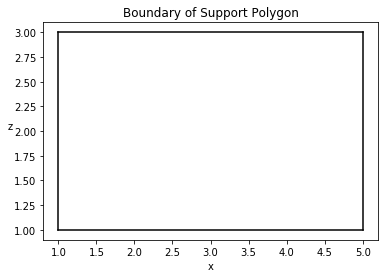

Point (3.214286, 1.785714) is inside the support polygon
Therefore, the structure is stable.


{'stability': True, 'structures': 1}

In [109]:
''' Executing code'''
calculate_stability(array, 10, 10, 6)